In [1]:
import sys
import yaml
import torch
import requests
import torchvision
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from warp_core.utils import load_or_fail

sys.path.append("..")
from training.train_c_controlnet import WurstCore
from training.train_b import WurstCore as WurstCoreB

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

ModuleNotFoundError: No module named 'training.train_c_controlnet'

In [ ]:
# SETUP WARPCORE
# config_file = 'configs/controlnet_c_3b_base.yml'
# config_file = 'configs/controlnet_c_3b_canny.yml'
# config_file = 'configs/controlnet_c_3b_inpainting.yml'
# config_file = 'configs/controlnet_c_3b_qr.yml'
# config_file = 'configs/controlnet_c_3b_sr.yml'
config_file = '../configs/inference/controlnet_c_3b_identity.yaml'
# config_file = 'configs/controlnet_c_3b_identity_v2.yml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)

warpcore = WurstCore(
    config_dict=loaded_config,
    device=device,
    training=False
)

# STAGE B
config_file_b = '../configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
warpcore_b = WurstCoreB(
    config_dict=config_file_b,
    device=device,
    training=False
)

In [8]:
from transformers import AutoTokenizer, CLIPModel, CLIPTextModelWithProjection
device = "cuda:0"

In [7]:
tokenizer = AutoTokenizer.from_pretrained("laion/CLIP-ViT-bigG-14-laion2B-39B-b160k")

In [ ]:
text_encoder = CLIPTextModelWithProjection.from_pretrained(
    "laion/CLIP-ViT-bigG-14-laion2B-39B-b160k"
).requires_grad_(False).to(device)

In [43]:
tokens = tokenizer("hello there", truncation=True, padding="max_length",
                                             max_length=tokenizer.model_max_length,
                                             return_tensors="pt").to(device)
emb = text_encoder(**tokens, output_hidden_states=True)
clip_text = emb.hidden_states[-1]
clip_text_pooled = emb.text_embeds

In [3]:
# SETUP MODELS & DATA
extras = warpcore.setup_extras_pre()
models = warpcore.setup_models(extras)
models.generator.bfloat16().eval().requires_grad_(False)
print("CONTROLNET READY")

extras_b = warpcore_b.setup_extras_pre()
models_b = warpcore_b.setup_models(extras_b)
models_b.generator.bfloat16().eval().requires_grad_(False)
print("STAGE B READY")
pass

['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess', 'controlnet_filter']
Starting Init Model
32.6188268661499
Starting Loading Checkpoint
38.28098273277283


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.4.self_attn.k_proj.bias', 'text_model.encoder.layers.3.layer_norm2.weight', 'text_model.encoder.layers.9.self_attn.v_proj.bias', 'text_model.encoder.layers.8.layer_norm2.weight', 'text_model.encoder.layers.8.self_attn.q_proj.weight', 'text_model.encoder.layers.2.layer_norm1.weight', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.9.self_attn.out_proj.bias', 'text_model.encoder.layers.1.layer_norm2.weight', 'text_projection.weight', 'text_model.encoder.layers.5.self_attn.k_proj.bias', 'text_model.encoder.layers.1.self_attn.out_proj.bias', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.5.self_attn.v_proj.bias',

['clip_tokenizer', 'clip_text_model', 'clip_text_model_proj', 'clip_image_model', 'generator', 'effnet', 'previewer', 'controlnet']
CONTROLNET READY
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['clip_tokenizer', 'clip_text_model', 'clip_text_model_proj', 'clip_image_model', 'generator', 'effnet', 'stage_a']
STAGE B READY


In [4]:
print("TOTAL PARAMS:", sum(p.numel() for p in models.controlnet.parameters() if p.requires_grad))
print("BACKBONE PARAMS:", sum(p.numel() for p in models.controlnet.backbone.parameters() if p.requires_grad))

TOTAL PARAMS: 102763008
BACKBONE PARAMS: 18876928


In [6]:
# LOAD CHECKPOINT
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_canny/controlnet_2k.safetensors"))
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_canny/controlnet_10k.safetensors"))
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_inpainting/controlnet_10k.safetensors"))
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_sr/controlnet_10k.safetensors"))
models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_identity/controlnet_200k.safetensors"))

<All keys matched successfully>

In [6]:
def download_image(url):
    return Image.open(requests.get(url, stream=True).raw).convert("RGB")

def show_images(imgs, **kwargs):
    plt.figure(figsize=(kwargs.get("width", 32), kwargs.get("height", 32)))
    plt.axis("off")
    plt.imshow(torch.cat([torch.cat([i for i in imgs], dim=-1)], dim=-2).permute(1, 2, 0).cpu(), cmap='Greys')
    plt.show()

torch.Size([4, 3, 1024, 1024])


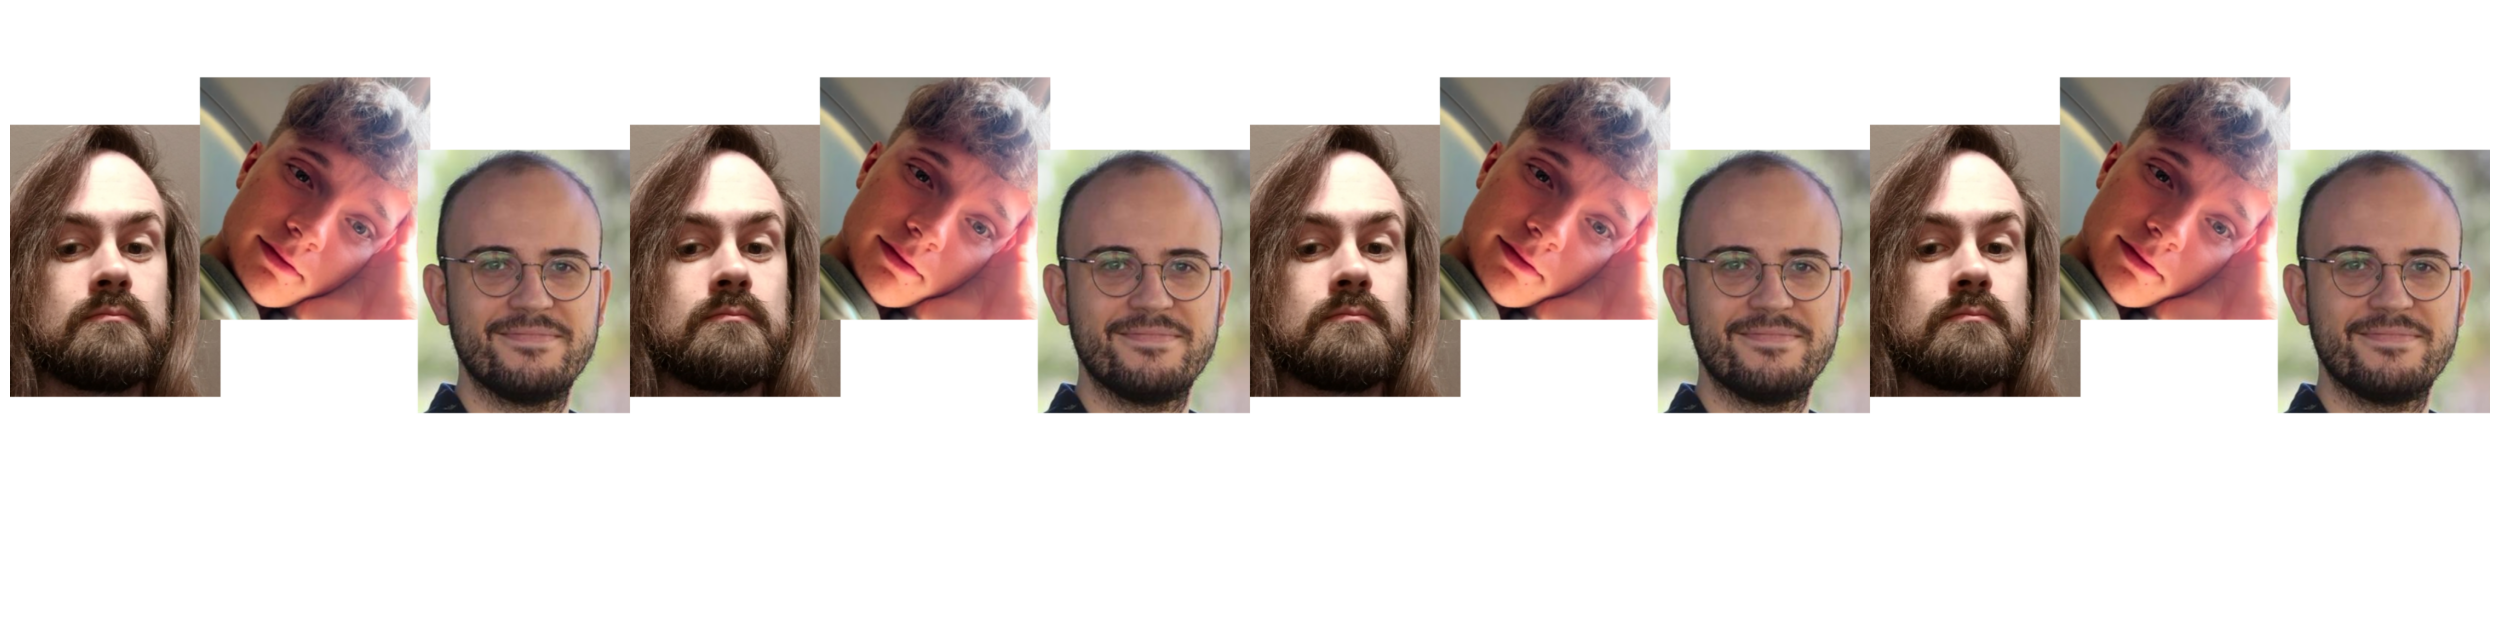

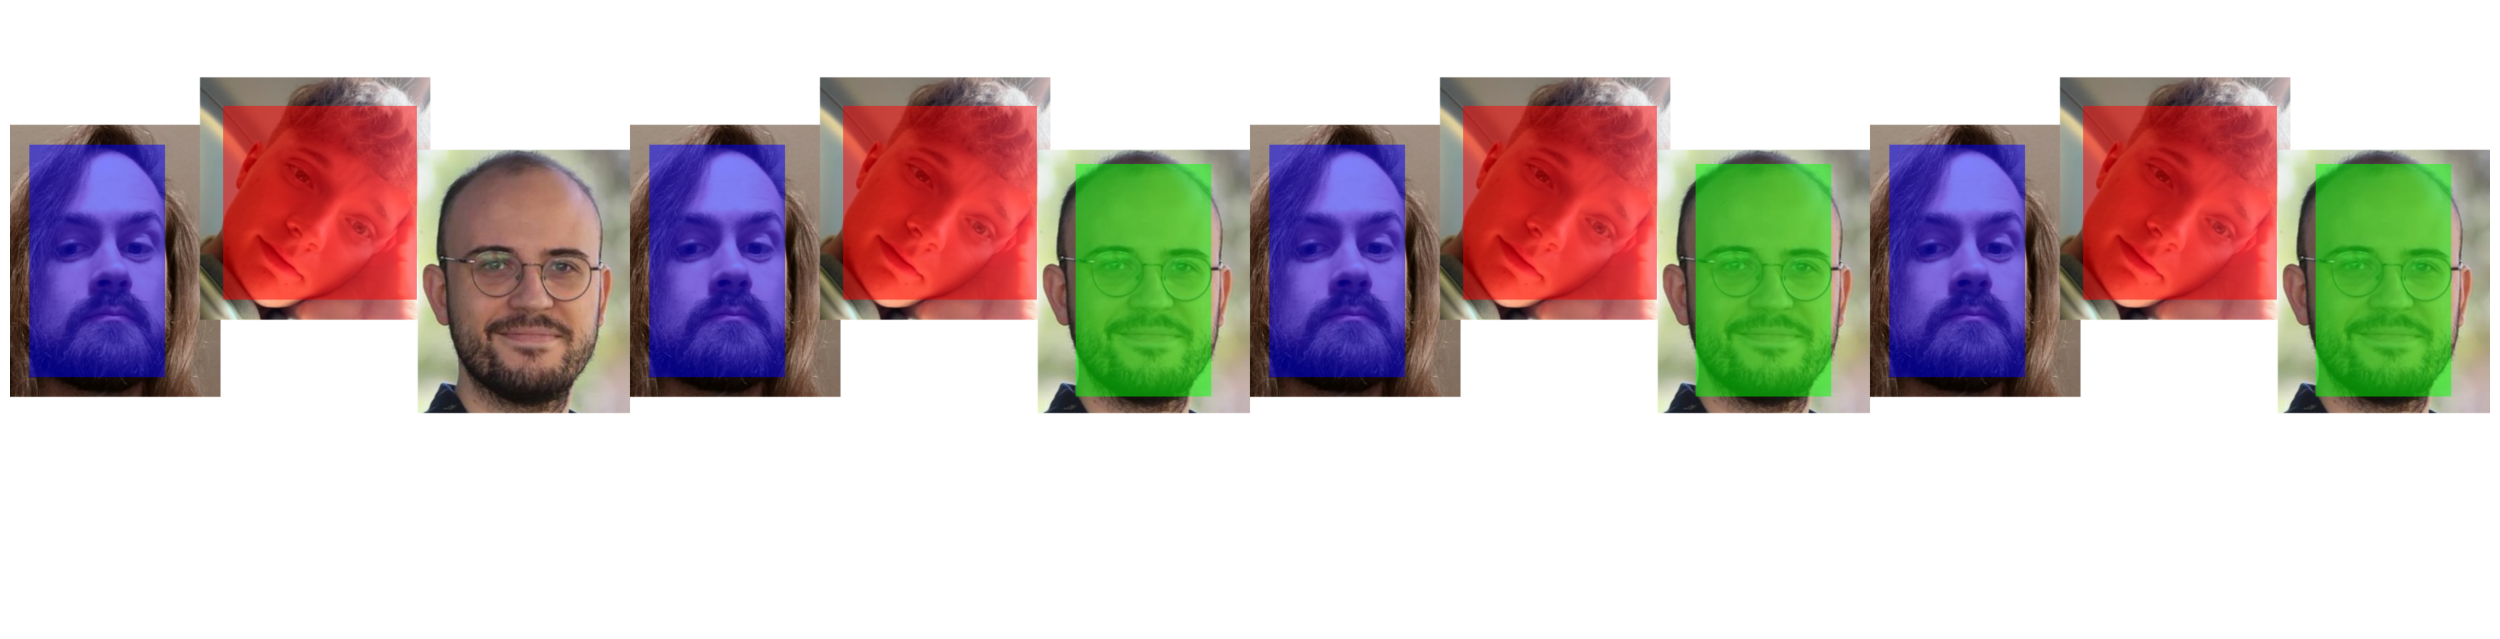

In [20]:
batch_size = 4
cnet_override = None
url = "https://cdn.discordapp.com/attachments/1039261364935462942/1200109692978999317/three_people.png?ex=65c4fc3f&is=65b2873f&hm=064a8cebea5560b74e7088be9d1399a5fe48863d1581e65ea9d6734725f4c8d3&" # Model Wranglers
images = extras.transforms(download_image(url)).unsqueeze(0).expand(batch_size, -1, -1, -1).to(device)

batch = {}
batch['images'] = images.cpu()
# batch['captions'] = ['In the style of Don Bluth, Jozef Szekeres. MCU closeup of group of men, the one in the right is bald, scenery from She-ra, flat animation, 8k'] * batch_size
batch['captions'] = ['a cute cat'] * batch_size

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    cnet, cnet_input = warpcore.get_cnet(batch, models, extras)
    cnet_uncond = warpcore.get_cnet({'images': torch.zeros_like(batch['images'])}, models, extras)[0]
    
if cnet_override is None:
    with torch.no_grad():
        if cnet_input.size(1) == 1:
            cnet_input = cnet_input.repeat(1, 3, 1, 1)
        elif cnet_input.size(1) > 3:
            cnet_input_extra_channels = cnet_input[:, 3:]     
            cnet_input = cnet_input[:, :3]     
        print(cnet_input.shape)
else:
    cnet = cnet_override
    cnet_input = 1-images.mean(dim=1, keepdim=True).cpu().expand(-1, 3, -1, -1)

show_images(batch['images'])
show_images(cnet_input)

In [11]:
# PREPARE CONDITIONS
conditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    

In [21]:
conditions["clip_text_pooled"]

tensor([[[-0.2935,  0.8795, -0.9182,  ..., -0.6775, -0.3750,  0.6524]],

        [[-0.2935,  0.8795, -0.9182,  ..., -0.6775, -0.3750,  0.6524]],

        [[-0.2935,  0.8795, -0.9182,  ..., -0.6775, -0.3750,  0.6524]],

        [[-0.2935,  0.8795, -0.9182,  ..., -0.6775, -0.3750,  0.6524]]],
       device='cuda:0')

In [12]:
# cnet[0].shape

cnet_input = extras.controlnet_filter(images)

In [13]:
cnet_multiplier = 1.0 # 0.8 # 0.3
conditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet]
# conditions['cnet'] = [c.clone().mean(dim=0, keepdim=True).expand(c.size(0), -1, -1, -1) * cnet_multiplier if c is not None else c for c in cnet] # BATCH IDENTITY MERGE
# unconditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet]
unconditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet_uncond]
print("CNet Layers:", [i for i, p in enumerate(conditions['cnet']) if p is not None])


CNet Layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


{'cfg': 4, 'sampler': <gdf.samplers.DDPMSampler object at 0x14b447a4aa30>, 'shift': 2, 'timesteps': 20}


/fsx/home-dome/env/lib/python3.8/site-packages/torch/random.py:151: UserWarning: CUDA reports that you have 8 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


torch.Size([4, 16, 24, 24]) torch.Size([4, 3, 192, 192])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


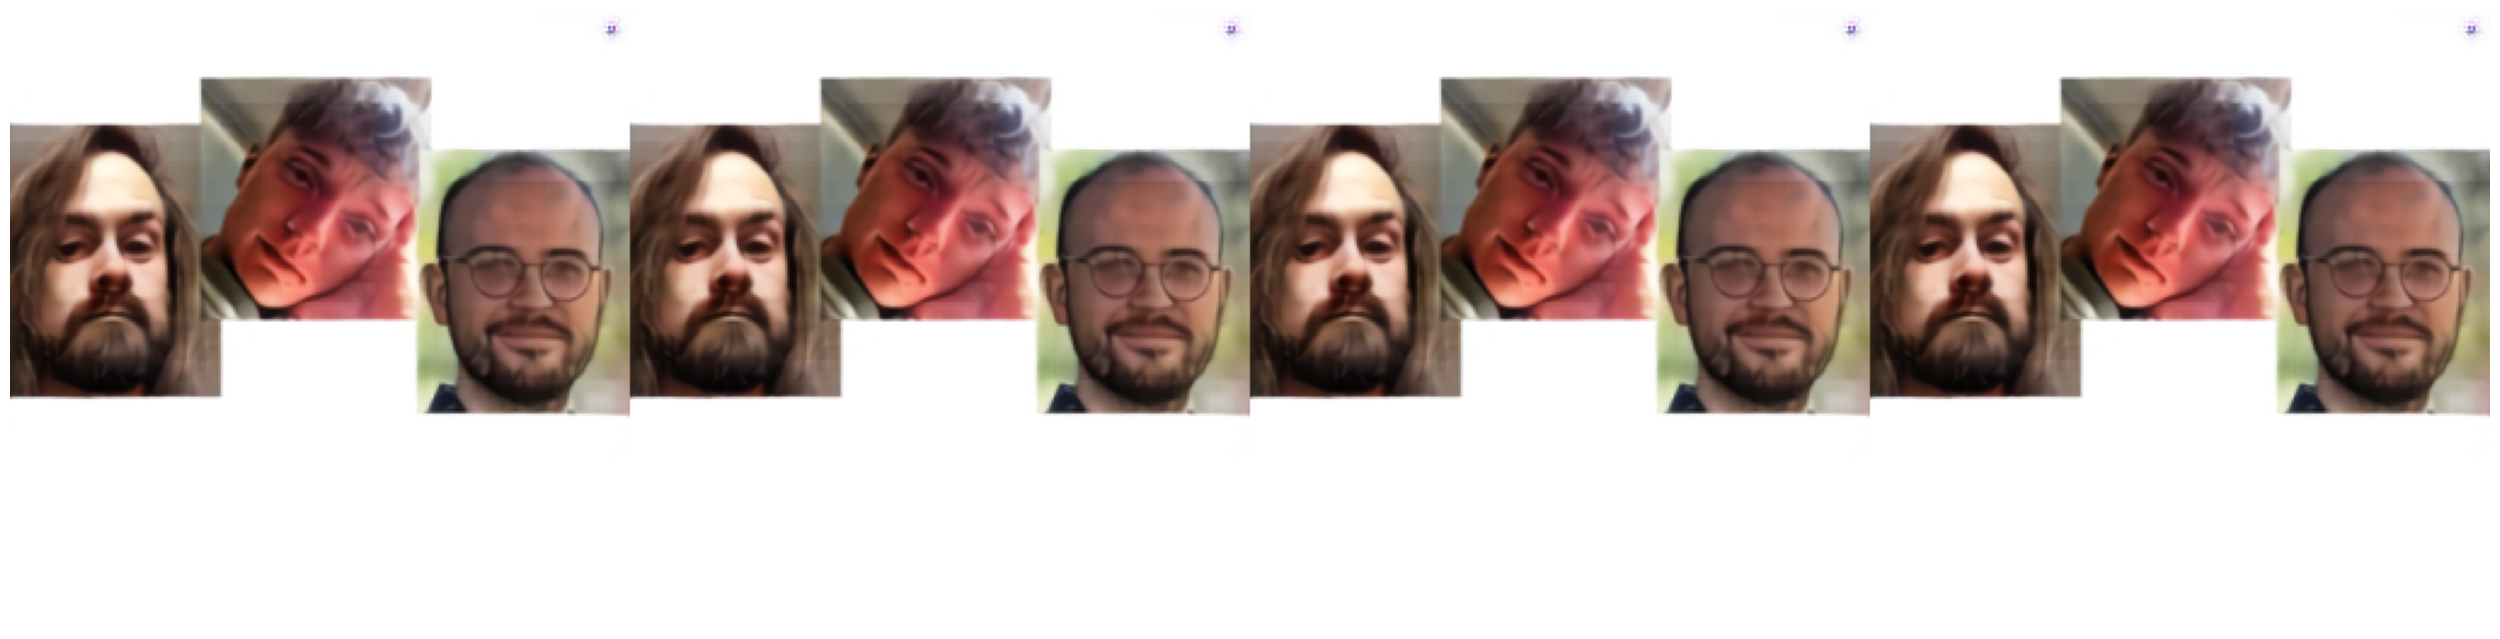

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


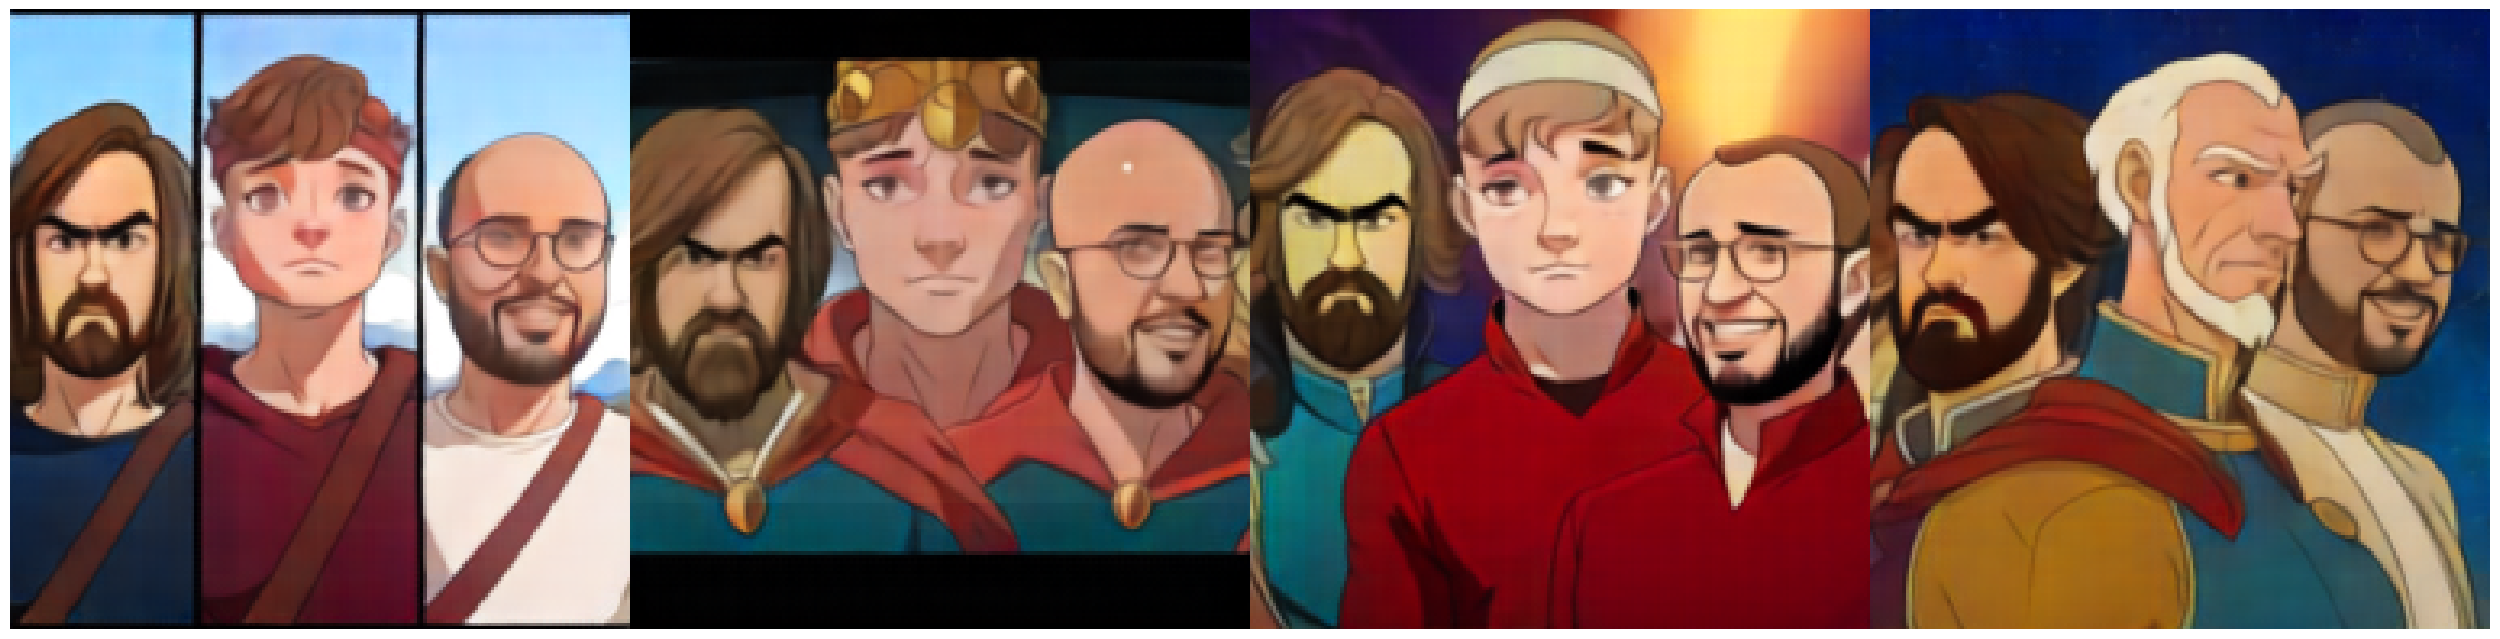

In [14]:
# SAMPLE
extras.sampling_configs['cfg'] = 4
extras.sampling_configs['shift'] = 2
extras.sampling_configs['timesteps'] = 20
# extras.sampling_configs['t_start'] = 1.0
print(extras.sampling_configs)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    *_, (sampled_latents, _, _) = extras.gdf.sample(
        models.generator, conditions, (4, 16, 24, 24), # (4, 16, 24, 24),
        unconditions, device=device, **extras.sampling_configs
    )
    sampled = models.previewer(sampled_latents).float()
    print(sampled_latents.shape, sampled.shape)
    
    effnet_latents = warpcore.encode_latents(batch, models, extras)
    decoded = models.previewer(effnet_latents).float()
show_images(decoded)
show_images(sampled)

In [15]:
# STAGE B SAMPLING
conditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True, eval_image_embeds=False)
conditions_b['effnet'] = sampled_latents
unconditions_b['effnet'] = torch.zeros_like(sampled_latents)


{'cfg': 1.5, 'sampler': <gdf.samplers.DDPMSampler object at 0x14b41cc09ca0>, 'shift': 1, 'timesteps': 10}
torch.Size([4, 16, 24, 24]) torch.Size([4, 3, 1024, 1024])


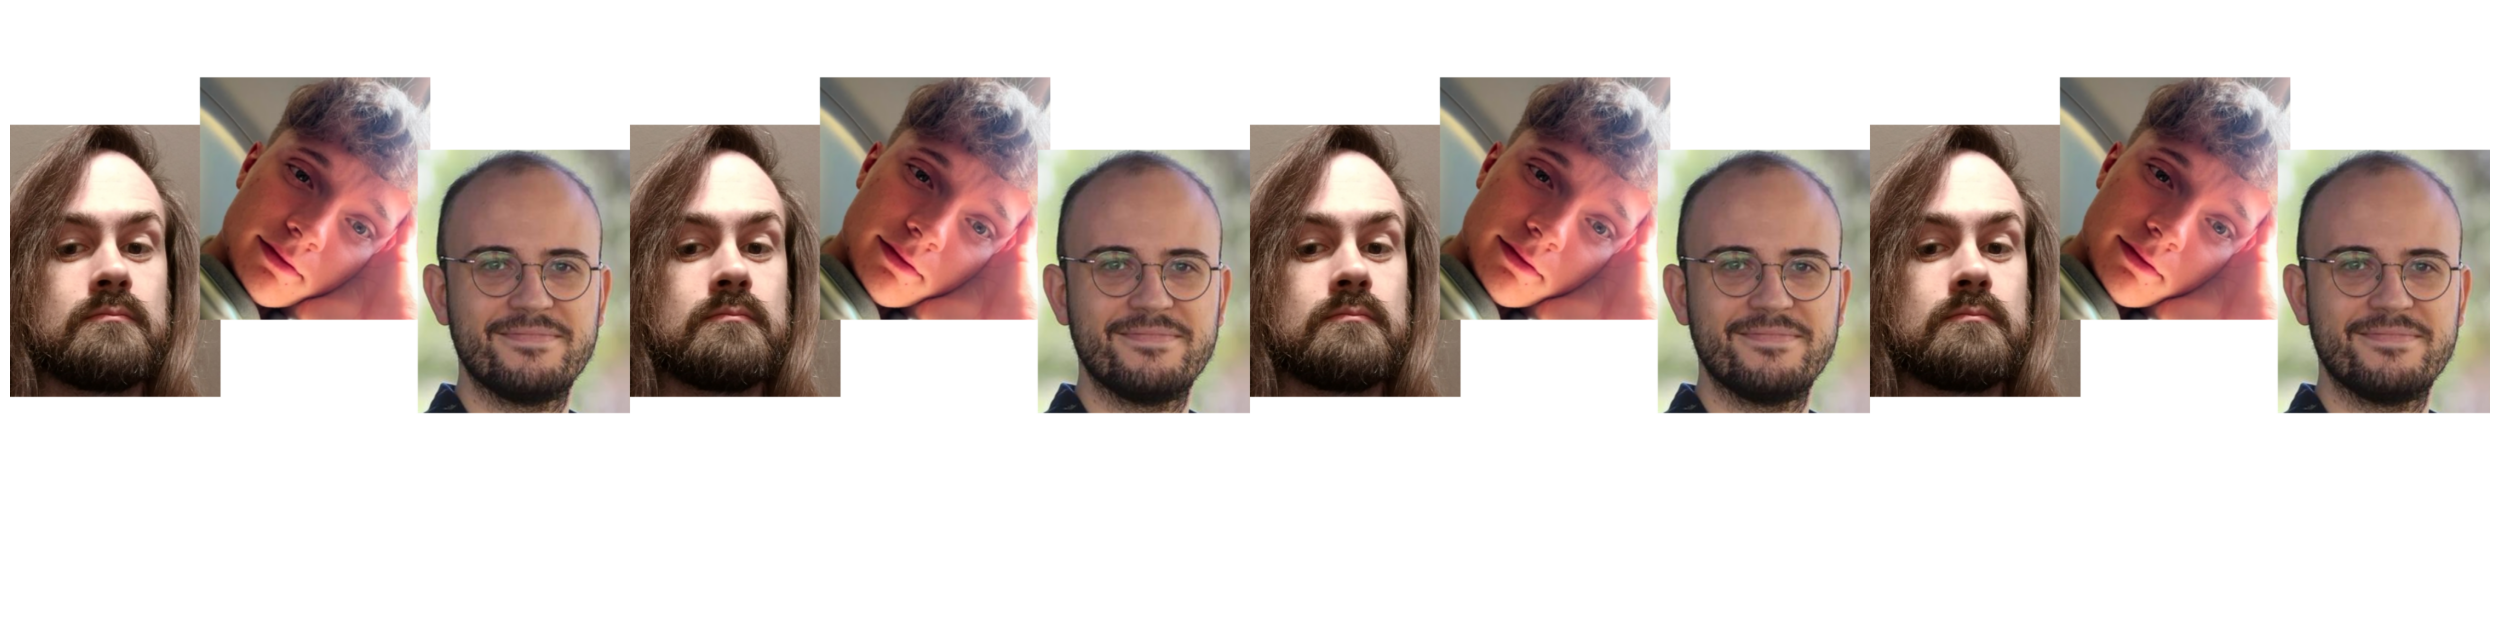

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


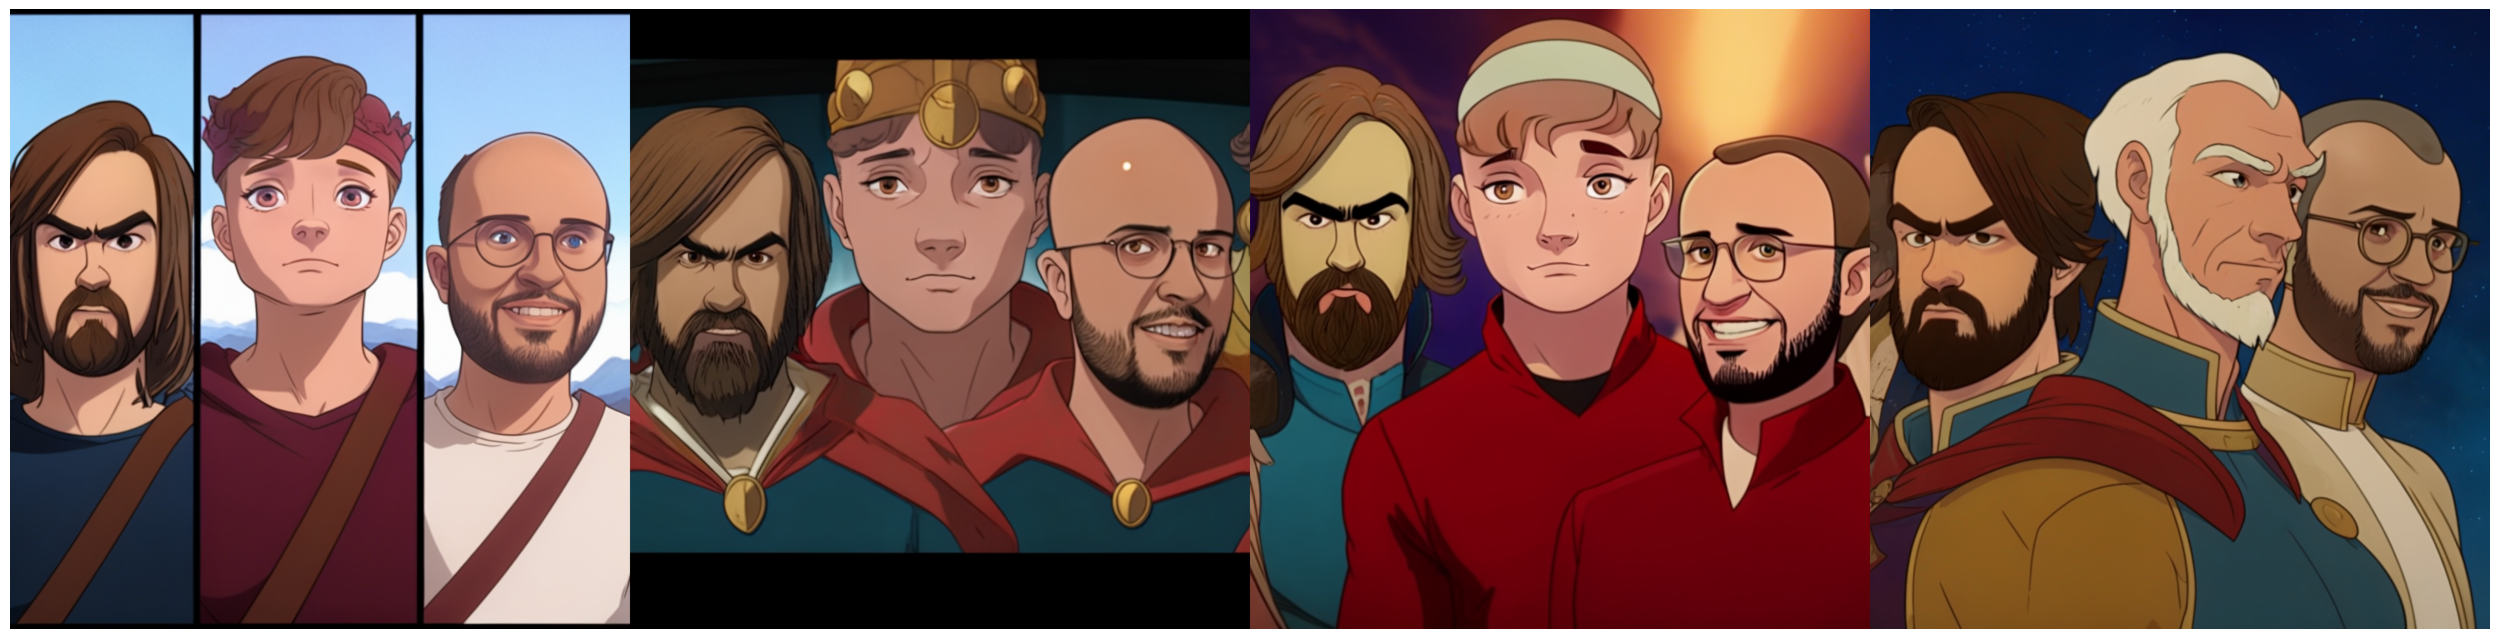

In [16]:
# SAMPLE
# extras_b.sampling_configs['cfg'] = 1.5
# extras_b.sampling_configs['shift'] = 1
# extras_b.sampling_configs['timesteps'] = 10
# extras_b.sampling_configs['t_start'] = 1.0
print(extras_b.sampling_configs)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    *_, (sampled_latents_b, _, _) = extras_b.gdf.sample(
        models_b.generator, conditions_b, (4, 4, 256, 256), # (4, 4, 256, 256),
        unconditions_b, device=device, **extras_b.sampling_configs
    )
    sampled_b = models_b.stage_a.decode(sampled_latents_b).float()
    print(sampled_latents.shape, sampled_b.shape)

show_images(batch['images'])
show_images(sampled_b)